In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns

In [2]:
iCMS_marker_genes = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv', )
iCMS3_up = list(iCMS_marker_genes['iCMS3_Up'].dropna())
iCMS3_dw = list(iCMS_marker_genes['iCMS3_Down'].dropna())
iCMS2_up = list(iCMS_marker_genes['iCMS2_Up'].dropna())
iCMS2_dw = list(iCMS_marker_genes['iCMS2_Down'].dropna())

## Chen et al

In [ ]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)
chen_metadata.head(1)

In [4]:
dict_SampleID_to_MSIstatus  = { SampleID : edf.iloc[0].MSI for SampleID, edf in chen_metadata.groupby("SampleID") }
dict_SampleID_to_Response   = { SampleID : edf.iloc[0].Response for SampleID, edf in chen_metadata.groupby("SampleID") }

In [5]:
chen_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.CRC.woSD.run_meta.organized.tsv', sep='\t',)
chen_metadata.head(1)

Accession SampleID PatientID TreatmentStage TreatmentPoint BiopsySite  \
0  HRR1372976  P04-N-I       P04            Pre       Baseline     Normal   

    MMR  MSI  TMB Response LibraryType    TumorLocation CancerType  
0  dMMR  MSI  487       CR   scRNA-seq  Ascending colon        CRC

In [6]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.h5ad')
adata = adata.raw.to_adata()

In [7]:
adata.obs['MSI']        = [ dict_SampleID_to_MSIstatus[SID] for SID in adata.obs['SampleID'] ]
adata.obs['Response']   = [ dict_SampleID_to_Response[SID] for SID in adata.obs['SampleID'] ]

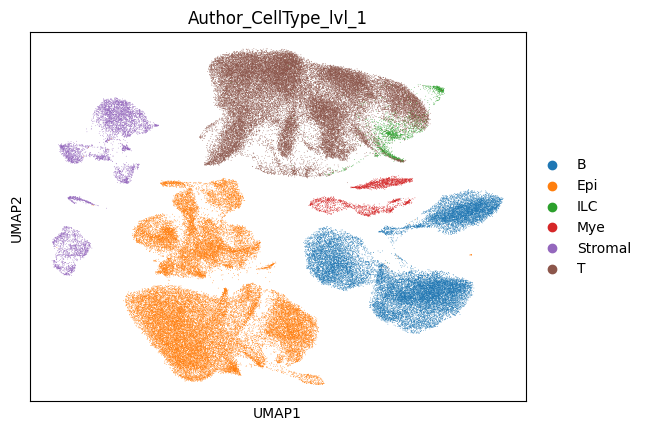

In [8]:
sc.pl.umap(adata, color=['Author_CellType_lvl_1',])

### Epithelial subclustering - Distinguishing Tumor vs. Normal epithelial

In [9]:
adata_epi = adata[(adata.obs['Author_CellType_lvl_1']=='Epi')].copy()

In [10]:
adata_epi.raw = adata_epi.copy()
sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


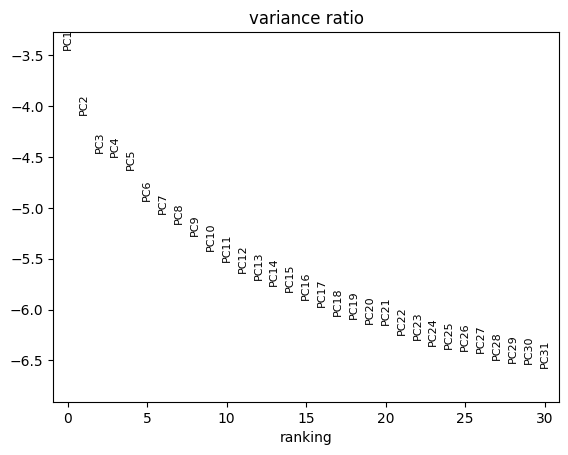

In [11]:
sc.pp.scale(adata_epi, max_value=10)
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [12]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

2024-12-20 15:20:06.849765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 15:20:06.851534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 15:20:06.856045: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 15:20:06.870522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 15:20:06.894029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [13]:
sc.tl.leiden(adata_epi, resolution=0.2)

/tmp/ipykernel_46850/2576127689.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_epi, resolution=0.2)


In [29]:
sc.tl.rank_genes_groups(adata_epi, groupby='leiden', use_raw=False,)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value enco

In [14]:
# Inspect patient-heterogeneity of each patient
l = list()

for leiden, edf in adata_epi.obs.groupby('leiden'):
    dict_SampleID_to_proportion = dict()
    for SampleID, edf2 in edf.groupby('SampleID'):
        dict_SampleID_to_proportion[SampleID] = len(edf2)/len(edf)
    dict_SampleID_to_proportion = dict(sorted(dict_SampleID_to_proportion.items(), key=lambda x:x[1], reverse=True))
    
    for SampleID, proportion in dict_SampleID_to_proportion.items():
        MajorSampleID = SampleID
        MajorProportion1 = proportion
        break 
    
    dict_BiopsySite_to_proportion = dict()
    for BiopsySite, edf2 in edf.groupby('BiopsySite'):
        dict_BiopsySite_to_proportion[BiopsySite] = len(edf2)/len(edf)
    
    print(f'{leiden}\t\t{round(100*MajorProportion1, 1)}\t\t\t{round(100*dict_BiopsySite_to_proportion['Normal'], 1)}\t\t{round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)}')
    l.append( [leiden, round(100*MajorProportion1, 1), round(100*dict_BiopsySite_to_proportion['Normal'], 1), round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)] )

l = pd.DataFrame(l, columns=['leiden', 'MajorPatientPerc', 'NormalSamplePerc', 'AvgSTRDiff'])

0		10.3			69.2		0.1
1		13.7			69.4		0.0
2		98.6			0.0		-1.0
3		99.4			0.0		-0.7
4		99.9			0.1		-1.9
5		97.5			0.8		-1.5
6		99.2			0.1		-2.1
7		36.9			84.9		0.1
8		95.5			98.3		0.1
9		98.9			0.2		-1.5
10		95.1			0.8		-2.3
11		22.8			88.2		0.1
12		98.6			0.5		-1.4
13		98.9			1.1		-1.4
14		96.3			2.5		-1.8
15		20.8			73.0		-0.0
16		17.9			73.1		-0.2
17		100.0			0.0		-1.6


/tmp/ipykernel_46850/3745268925.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for leiden, edf in adata_epi.obs.groupby('leiden'):
/tmp/ipykernel_46850/3745268925.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf2 in edf.groupby('SampleID'):
/tmp/ipykernel_46850/3745268925.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for BiopsySite, edf2 in edf.groupby('BiopsySite'):


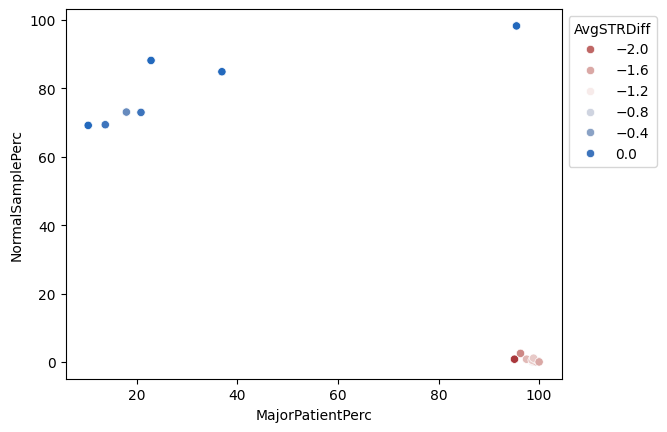

In [17]:
ax = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='AvgSTRDiff', palette='vlag_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
""" 
0		10.3			69.2		0.1     True
1		13.7			69.4		0.0     True
2		98.6			0.0		-1.0        False
3		99.4			0.0		-0.7        False
4		99.9			0.1		-1.9        False
5		97.5			0.8		-1.5        False
6		99.2			0.1		-2.1        False
7		36.9			84.9		0.1     True
8		95.5			98.3		0.1     True
9		98.9			0.2		-1.5        False
10		95.1			0.8		-2.3        False
11		22.8			88.2		0.1     True
12		98.6			0.5		-1.4        False
13		98.9			1.1		-1.4        False
14		96.3			2.5		-1.8        False
15		20.8			73.0		-0.0    True
16		17.9			73.1		-0.2    True
17		100.0			0.0		-1.6        False
"""

In [31]:
dict_leiden_to_EpiCellType = {
    '0' : 'Normal epithelial',
    '1' : 'Normal epithelial',
    '7' : 'Normal epithelial',
    '8' : 'Normal epithelial',
    '11' : 'Normal epithelial',
    '15' : 'Normal epithelial',
    '16' : 'Normal epithelial',

    '2' : 'Tumor epithelial',
    '3' : 'Tumor epithelial',
    '4' : 'Tumor epithelial',
    '5' : 'Tumor epithelial',
    '6' : 'Tumor epithelial',
    '9' : 'Tumor epithelial',
    '10' : 'Tumor epithelial',
    '12' : 'Tumor epithelial',
    '13' : 'Tumor epithelial',
    '14' : 'Tumor epithelial',
    '17' : 'Tumor epithelial',
}

adata_epi.obs['Manual_CellType_lvl_1'] = [ dict_leiden_to_EpiCellType[leiden] for leiden in adata_epi.obs['leiden'] ]

In [35]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)
dict_PatientID_to_TumorLoc   = { list(tup)[1] : list(tup)[5] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorLoc['P15'] = 'Sigmoid colon'
dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_CancerType = { list(tup)[1] : list(tup)[4] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi.obs['TumorLocation'] = [ dict_PatientID_to_TumorLoc[PID] for PID in adata_epi.obs['PatientID'] ]
adata_epi.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi.obs['PatientID'] ]
adata_epi.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi.obs['PatientID'] ]
adata_epi.obs['CancerType'] = [ dict_PatientID_to_CancerType[PID] for PID in adata_epi.obs['PatientID'] ]
adata_epi.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi.obs['PatientID'] ]

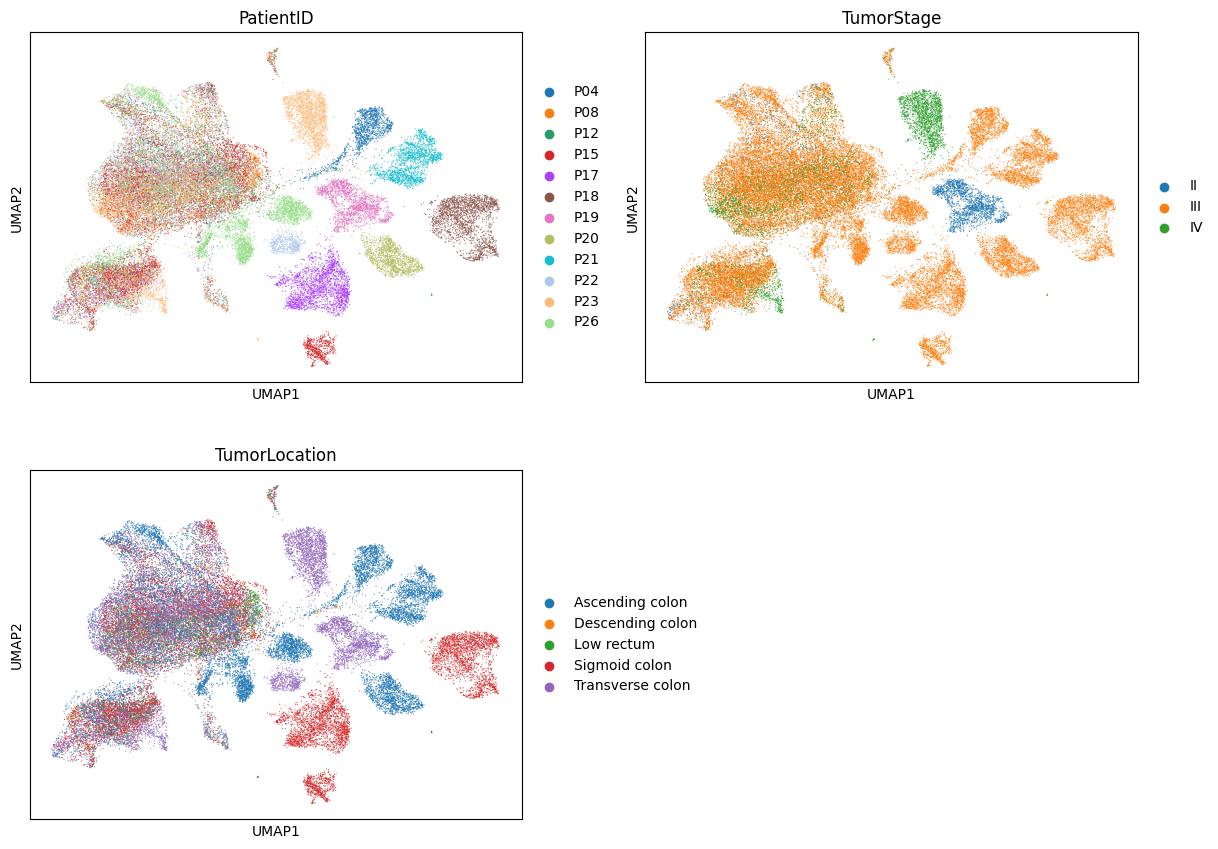

In [38]:
sc.pl.umap(adata_epi, color=['PatientID', 'TumorStage', 'TumorLocation'], ncols=2,
           cmap='vlag_r', vmin=-3, vmax=3, alpha=0.75,
)

In [39]:
len(set(adata_epi.obs['PatientID']))

12

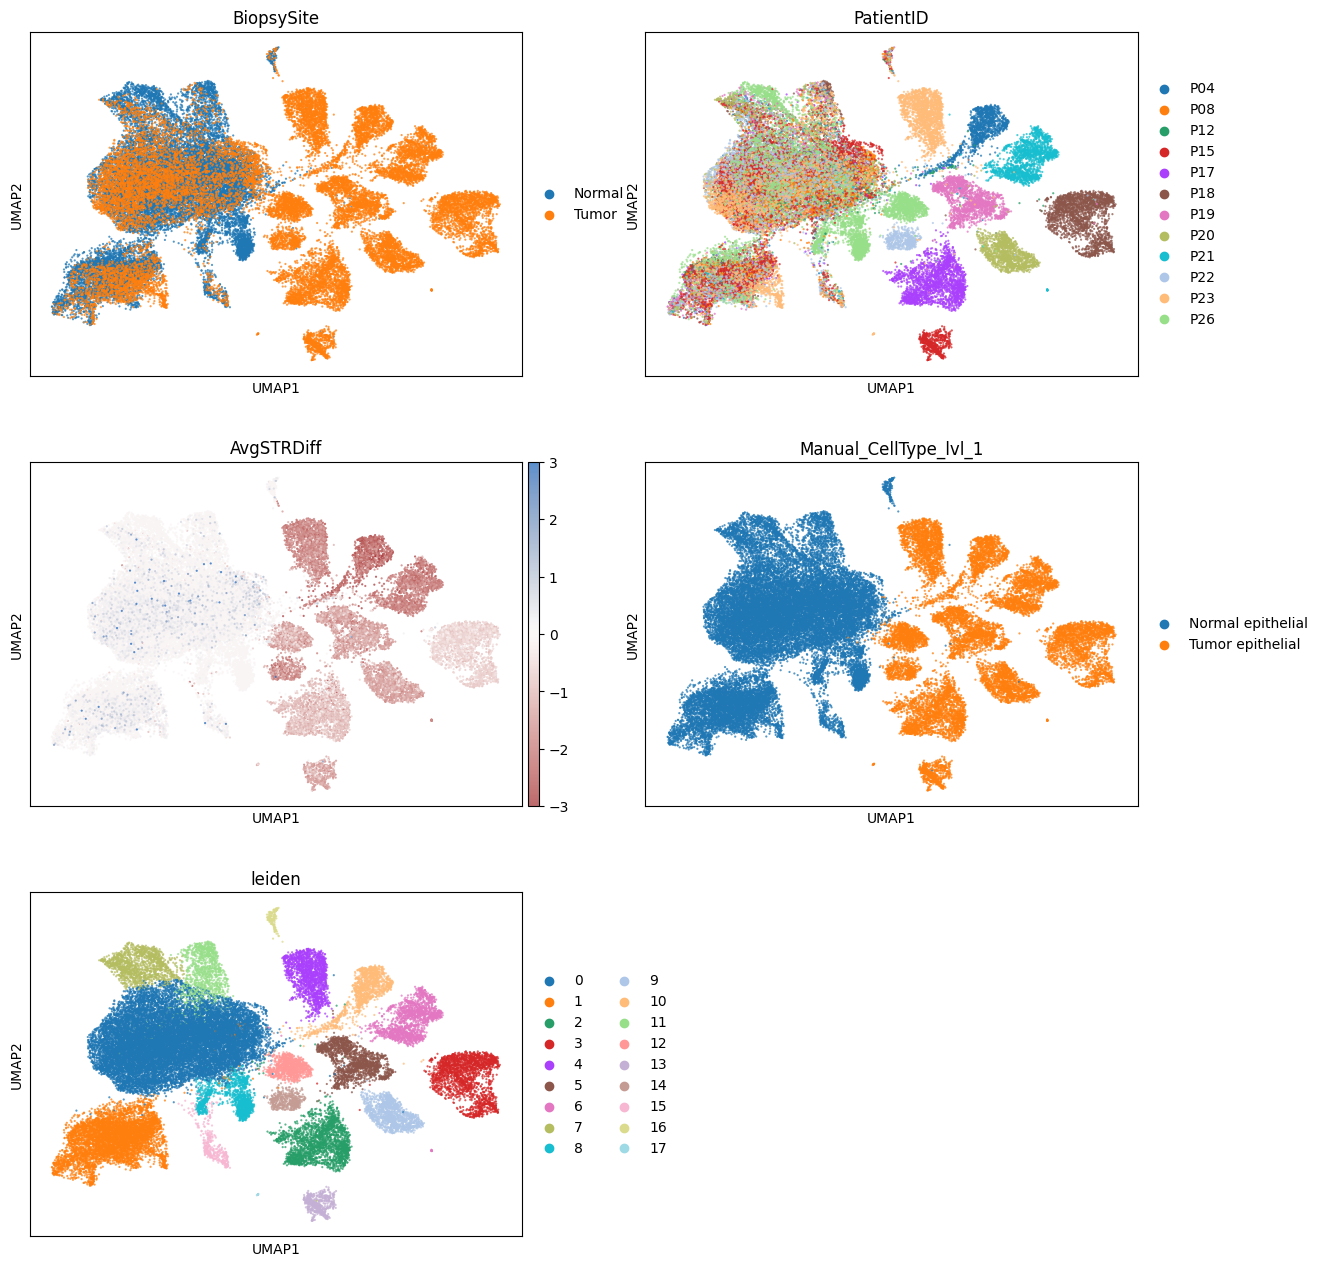

In [40]:
sc.pl.umap(adata_epi, color=['BiopsySite', 'PatientID', 'AvgSTRDiff', 'Manual_CellType_lvl_1', 'leiden'], ncols=2,
           cmap='vlag_r', vmin=-3, vmax=3, size=10, alpha=0.75,
)

### No tumor cells for P08 and P12?

#### P08 → No tumor cells

In [41]:
adata_epi_P08 = adata[(adata.obs['Author_CellType_lvl_1']=='Epi') & (adata.obs['PatientID'].isin(['P08',]))].copy()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


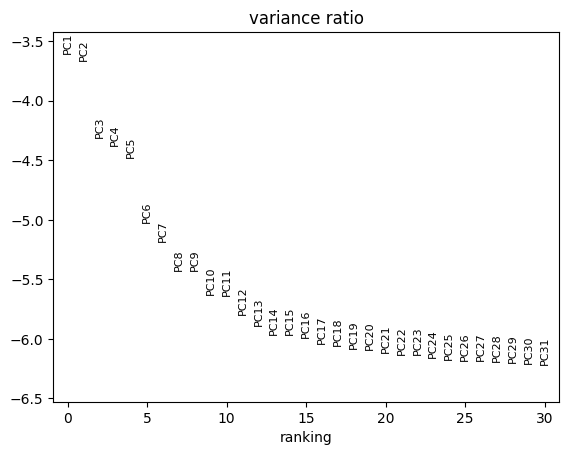

In [42]:
sc.pp.normalize_total(adata_epi_P08)
sc.pp.log1p(adata_epi_P08)
sc.pp.highly_variable_genes(adata_epi_P08, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi_P08, max_value=10)
adata_epi_P08.raw = adata_epi_P08.copy()
adata_epi_P08 = adata_epi_P08[:, adata_epi_P08.var.highly_variable]

sc.tl.pca(adata_epi_P08, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi_P08, log=True)

sc.pp.neighbors(adata_epi_P08, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_P08,)

In [43]:
sc.tl.leiden(adata_epi_P08, resolution=0.2)

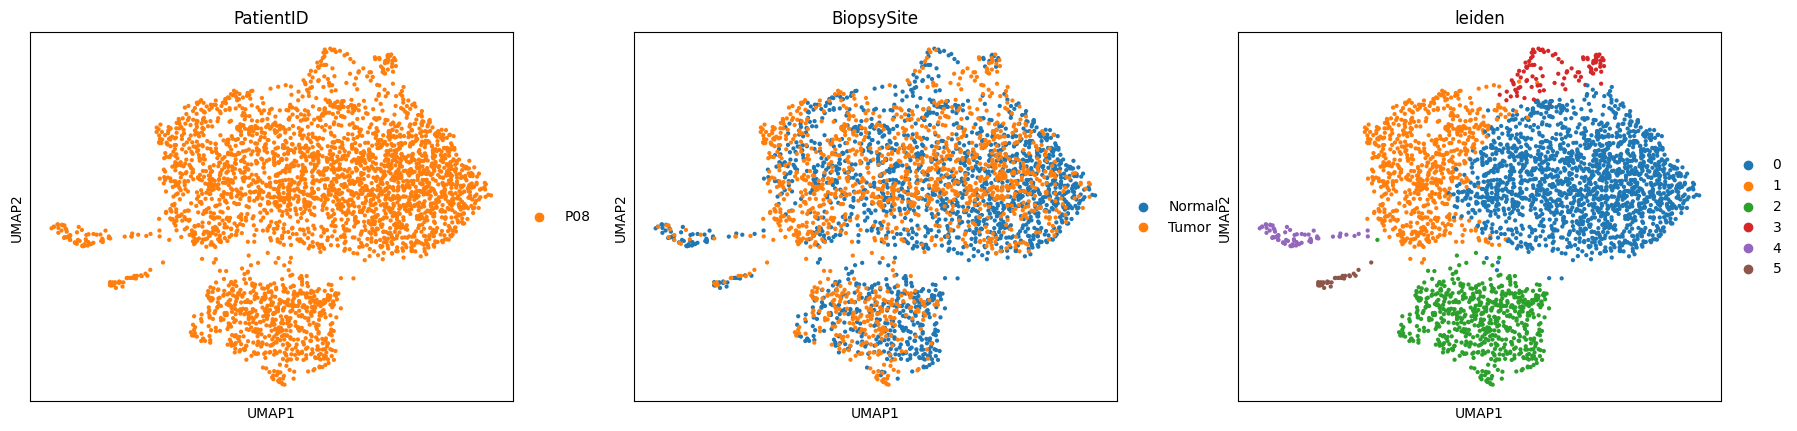

In [44]:
sc.pl.umap(adata_epi_P08, color=['PatientID', 'BiopsySite', 'leiden'])

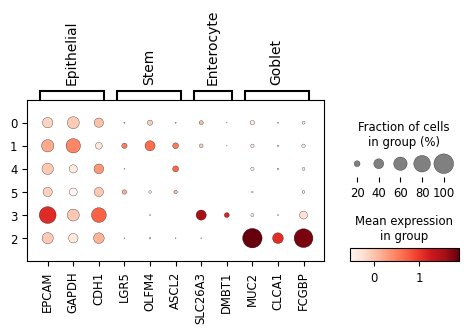

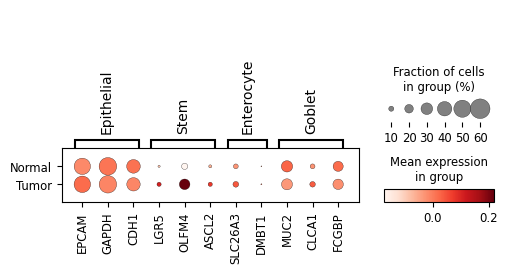

In [45]:
sc.pl.dotplot(adata_epi_P08, var_names={ 'Epithelial' : ['EPCAM', 'GAPDH', 'CDH1',], 
                                           'Stem' : ['LGR5', 'OLFM4', 'ASCL2'],
                                           'Enterocyte' : ['SLC26A3', 'DMBT1', ],
                                           'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', ],
                                           }, groupby='leiden', categories_order=['0', '1', '4', '5', '3', '2'])
sc.pl.dotplot(adata_epi_P08, var_names={ 'Epithelial' : ['EPCAM', 'GAPDH', 'CDH1',], 
                                           'Stem' : ['LGR5', 'OLFM4', 'ASCL2'],
                                           'Enterocyte' : ['SLC26A3', 'DMBT1', ],
                                           'Goblet' : ['MUC2', 'CLCA1', 'FCGBP', ],
                                           }, groupby='BiopsySite',)

In [46]:
adata_epi_P08.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TumorUnidentified/P08.epi.h5ad')

#### P12 → iCMS2

In [47]:
adata_epi_P12 = adata[(adata.obs['Author_CellType_lvl_1']=='Epi') & (adata.obs['PatientID'].isin(['P12',]))].copy()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


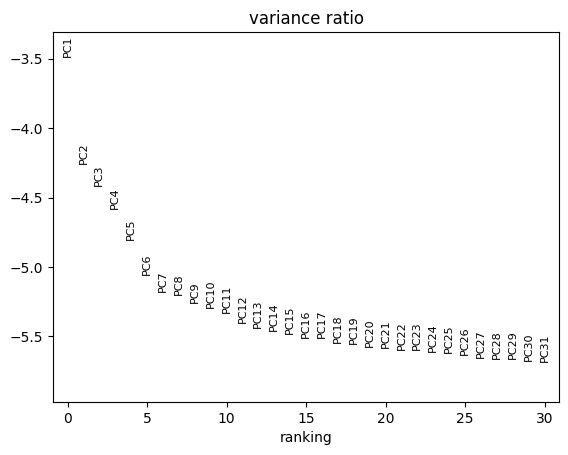

In [48]:
sc.pp.normalize_total(adata_epi_P12)
sc.pp.log1p(adata_epi_P12)
sc.pp.highly_variable_genes(adata_epi_P12, n_top_genes=2000, batch_key="SampleID")
sc.pp.scale(adata_epi_P12, max_value=10)
adata_epi_P12.raw = adata_epi_P12.copy()
adata_epi_P12 = adata_epi_P12[:, adata_epi_P12.var.highly_variable]

sc.tl.pca(adata_epi_P12, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi_P12, log=True)

sc.pp.neighbors(adata_epi_P12, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi_P12,)

In [49]:
sc.tl.leiden(adata_epi_P12, resolution=0.2)

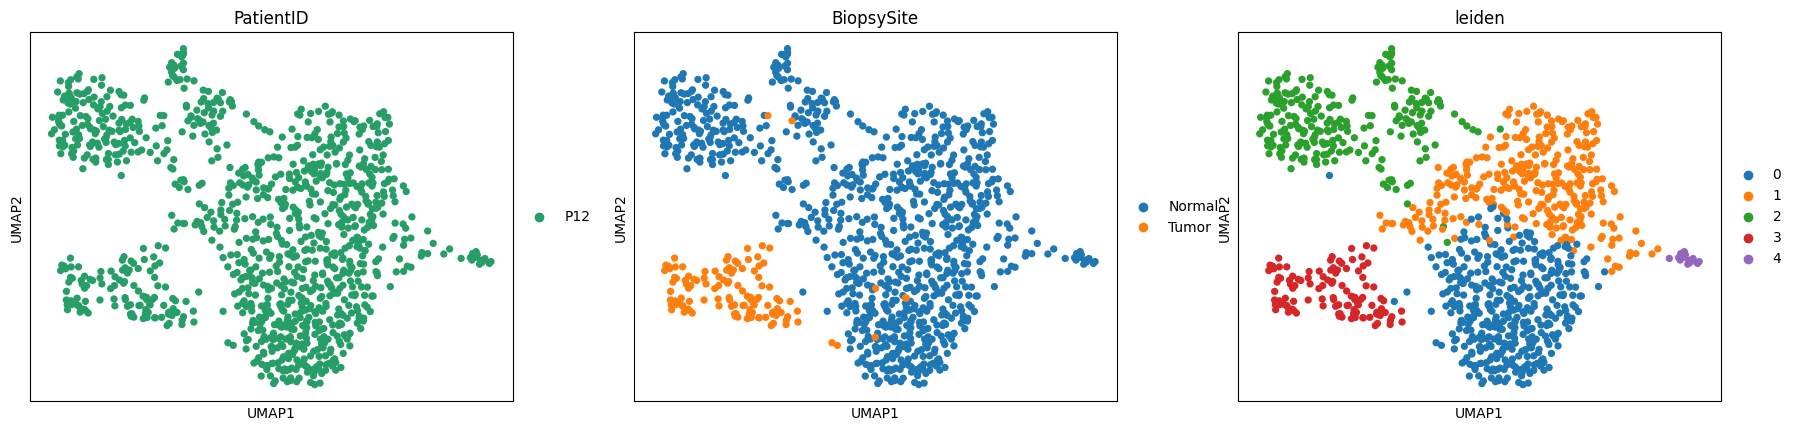

In [50]:
sc.pl.umap(adata_epi_P12, color=['PatientID', 'BiopsySite', 'leiden', ])

In [51]:
sc.tl.score_genes(adata_epi_P12, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_epi_P12, iCMS3_dw, score_name='iCMS3_dw')
sc.tl.score_genes(adata_epi_P12, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_epi_P12, iCMS2_dw, score_name='iCMS2_dw')

       'C8orf59', 'AC004130.1', 'NUPL2'],
      dtype='object')


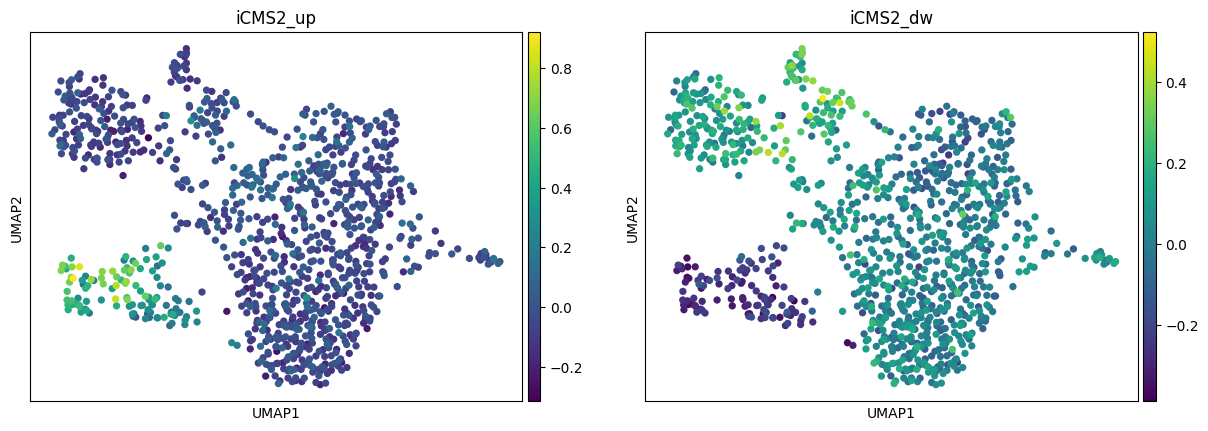

In [52]:
sc.pl.umap(adata_epi_P12, color=['iCMS2_up', 'iCMS2_dw',], )

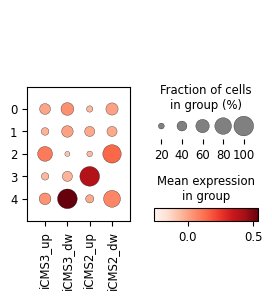

In [53]:
sc.pl.dotplot(adata_epi_P12,var_names=['iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', ], groupby='leiden')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value enco

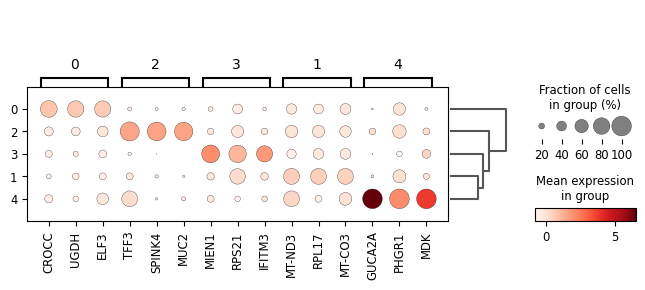

In [54]:
sc.tl.rank_genes_groups( adata_epi_P12, groupby='leiden',  )
sc.pl.rank_genes_groups_dotplot(adata_epi_P12, n_genes=3)

In [55]:
adata_epi_P12.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TumorUnidentified/P12.epi.h5ad')

### Check iCMS of each patient (all but P12 is iCMS3)

In [56]:
sc.tl.score_genes(adata_epi, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata_epi, iCMS3_dw, score_name='iCMS3_dw')
sc.tl.score_genes(adata_epi, iCMS2_up, score_name='iCMS2_up')
sc.tl.score_genes(adata_epi, iCMS2_dw, score_name='iCMS2_dw')

       'C8orf59', 'AC004130.1', 'NUPL2'],
      dtype='object')


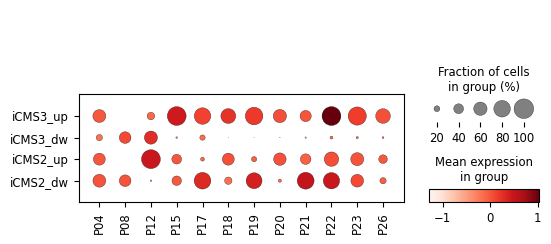

In [57]:
sc.pl.dotplot(adata_epi[adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'],
              var_names=['iCMS3_up', 'iCMS3_dw', 'iCMS2_up', 'iCMS2_dw', ], groupby='PatientID', swap_axes=True)

In [58]:
for PatientID, edf in adata_epi[adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby('PatientID'):
    print(PatientID, 
          round((np.mean(edf['iCMS3_up'])-np.mean(edf['iCMS3_dw'])) - (np.mean(edf['iCMS2_up'])-np.mean(edf['iCMS2_dw'])), 2), 
          round((np.mean(edf['iCMS3_up'])-np.mean(edf['iCMS3_dw'])) / (np.mean(edf['iCMS2_up'])-np.mean(edf['iCMS2_dw'])), 2))

P04 0.17 -9.83
P08 -0.08 3.81
P12 -1.11 -0.54
P15 0.77 41.69
P17 0.69 -0.65
P18 1.31 7.44
P19 0.94 -1.15
P20 0.31 2.48
P21 1.2 -1.06
P22 1.65 -2.95
P23 0.43 -5.7
P26 0.14 4.22


/tmp/ipykernel_46850/2939463993.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi[adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].obs.groupby('PatientID'):


### Label results

In [59]:
# Reload adata because we did adata = adata.raw.to_adata()
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.h5ad')

adata.obs['MSI']        = [ dict_SampleID_to_MSIstatus[SID] for SID in adata.obs['SampleID'] ]
adata.obs['Response']   = [ dict_SampleID_to_Response[SID] for SID in adata.obs['SampleID'] ]
adata = adata[adata.obs['Response']!='SD'].copy()

In [60]:
dict_Identifier_to_ManualCellTypeLvl1 = { tup.Identifier : tup.Manual_CellType_lvl_1 for tup in adata_epi.obs.itertuples() }
for tup in adata.obs.itertuples():
    try:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier]
    except KeyError:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier] = 'N/A'

adata.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_ManualCellTypeLvl1[identifier] for identifier in adata.obs['Identifier'] ]

In [61]:
adata[~(adata.obs['PatientID'].isin(['P08', 'P12']))].write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_epi[~(adata_epi.obs['PatientID'].isin(['P08', 'P12']))].write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [62]:
adata.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/AllPatients/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_epi.write('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/AllPatients/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')

## Joanito et al

In [ ]:
joanito_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/CRC-SG1/synapse-metadata/patient_clinical_information.csv', encoding = "ISO-8859-1")
joanito_metadata = joanito_metadata[joanito_metadata['dataset'].isin(['CRC-SG1', 'KUL5', 'KUL3'])].copy()

dict_PatientID_to_MSIstatus  = { list(tup)[2] : tup.MSS_MSI for tup in joanito_metadata.itertuples() }

In [315]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.h5ad')
adata = adata.raw.to_adata()

In [322]:
adata.obs['MSI'] = [ dict_PatientID_to_MSIstatus[PatientID] for PatientID in adata.obs['PatientID'] ]

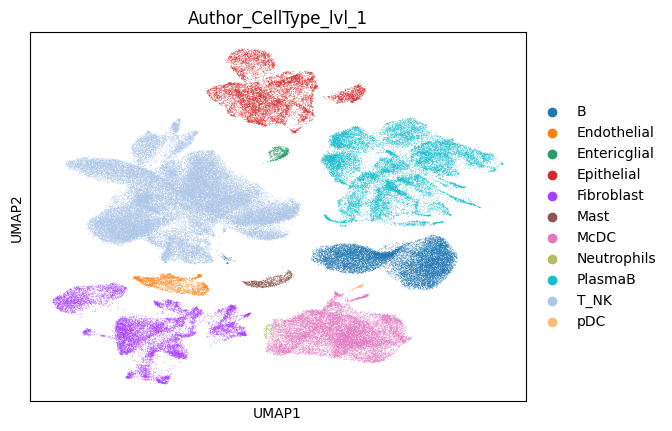

In [325]:
sc.pl.umap(adata, color=['Author_CellType_lvl_1',])

### Epithelial subclustering - Distinguishing Tumor vs. Normal epithelial

In [330]:
adata_epi = adata[(adata.obs['Author_CellType_lvl_1']=='Epithelial')].copy()

In [335]:
onlySingleCellSample = list()
for SampleID, edf in adata_epi.obs.groupby("SampleID"):
    if len(edf) <= 1:
        print(SampleID)
        onlySingleCellSample.append(SampleID)
adata_epi = adata_epi[~(adata_epi.obs['SampleID'].isin(onlySingleCellSample))].copy()

/tmp/ipykernel_170898/2165763383.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_epi.obs.groupby("SampleID"):


XHC166


In [336]:
adata_epi.raw = adata_epi.copy()
sc.pp.normalize_total(adata_epi)
sc.pp.log1p(adata_epi)
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


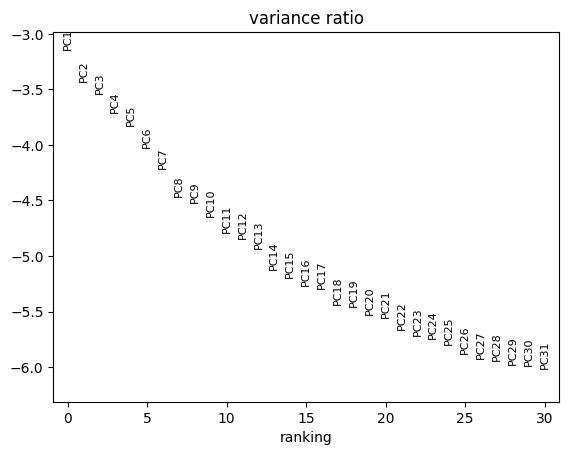

In [337]:
sc.pp.scale(adata_epi, max_value=10)
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [338]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

In [357]:
sc.tl.leiden(adata_epi, resolution=0.15)

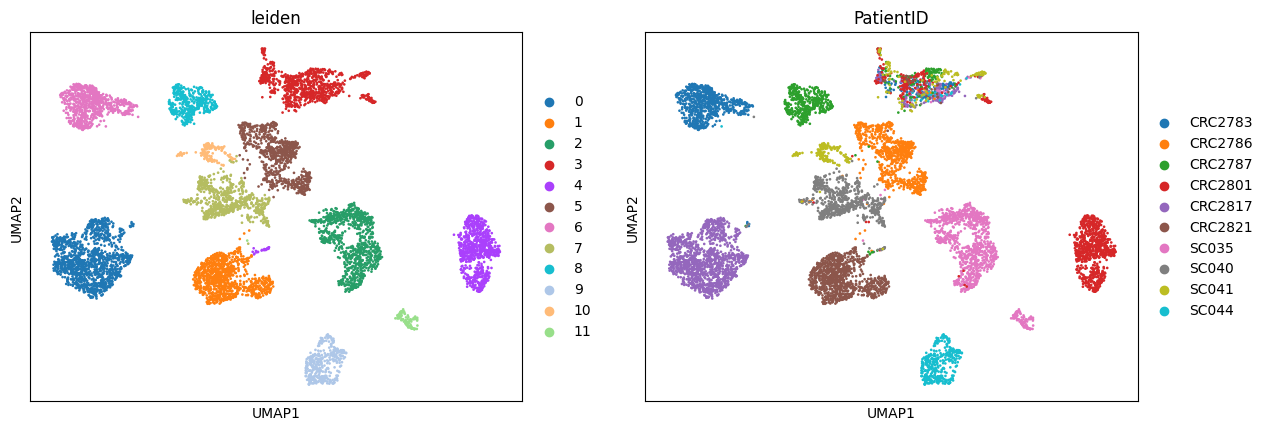

In [358]:
sc.pl.umap(adata_epi, color=['leiden', 'PatientID'])

In [340]:
dict_BiopsySite_to_BiopsySite2 = {
    'Adjacent normal tissue' : 'Normal',
    'Core' : 'Tumor',
    'Invasive' : 'Tumor',
    'LymphNode' : 'Tumor',
    'Normal' : 'Normal',
    'Tumor' : 'Tumor'
}

adata_epi.obs['BiopsySite2'] = [ dict_BiopsySite_to_BiopsySite2[BS] for BS in adata_epi.obs['BiopsySite'] ]

In [373]:
# Inspect patient-heterogeneity of each patient
l = list()

for leiden, edf in adata_epi.obs.groupby('leiden'):
    dict_PatientID_to_proportion = dict()
    for PatientID, edf2 in edf.groupby('PatientID'):
        dict_PatientID_to_proportion[PatientID] = len(edf2)/len(edf)
    dict_PatientID_to_proportion = dict(sorted(dict_PatientID_to_proportion.items(), key=lambda x:x[1], reverse=True))
    
    for PatientID, proportion in dict_PatientID_to_proportion.items():
        MajorPatientID = PatientID
        MajorProportion1 = proportion
        break 
    
    dict_BiopsySite_to_proportion = dict()
    for BiopsySite, edf2 in edf.groupby('BiopsySite2'):
        dict_BiopsySite_to_proportion[BiopsySite] = len(edf2)/len(edf)
    
    print(f'{leiden}\t\t{round(100*MajorProportion1, 1)}\t\t\t{round(100*dict_BiopsySite_to_proportion['Normal'], 1)}\t\t{round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)}')
    l.append( [leiden, round(100*MajorProportion1, 1), round(100*dict_BiopsySite_to_proportion['Normal'], 1), round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)] )

l = pd.DataFrame(l, columns=['leiden', 'MajorPatientPerc', 'NormalSamplePerc', 'AvgSTRDiff'])

0		99.3			0.4		-0.6
1		99.7			0.0		-0.0
2		99.6			0.0		-1.5
3		20.1			70.4		-0.1
4		97.2			1.2		-0.1
5		99.1			1.4		-0.1
6		99.7			0.0		-1.6
7		96.5			51.2		0.1
8		100.0			0.0		-0.1
9		100.0			0.0		-2.5
10		100.0			0.0		0.1
11		100.0			0.0		-1.9


/tmp/ipykernel_170898/1372756051.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for leiden, edf in adata_epi.obs.groupby('leiden'):
/tmp/ipykernel_170898/1372756051.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf2 in edf.groupby('PatientID'):
/tmp/ipykernel_170898/1372756051.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for BiopsySite, edf2 in edf.groupby('BiopsySite2'):


In [407]:
dict_leiden_to_EpiCellType = {
    '3' : 'Normal epithelial',

    '0' : 'Tumor epithelial',
    '1' : 'Tumor epithelial',
    '2' : 'Tumor epithelial',
    '4' : 'Tumor epithelial',
    '5' : 'Tumor epithelial',
    '6' : 'Tumor epithelial',
    '8' : 'Tumor epithelial',
    '9' : 'Tumor epithelial',
    '10' : 'Tumor epithelial',
    '11' : 'Tumor epithelial',
    '7' : 'Tumor epithelial', #! Mixed with NAT

}

adata_epi.obs['Manual_CellType_lvl_1'] = [ dict_leiden_to_EpiCellType[leiden] for leiden in adata_epi.obs['leiden'] ]

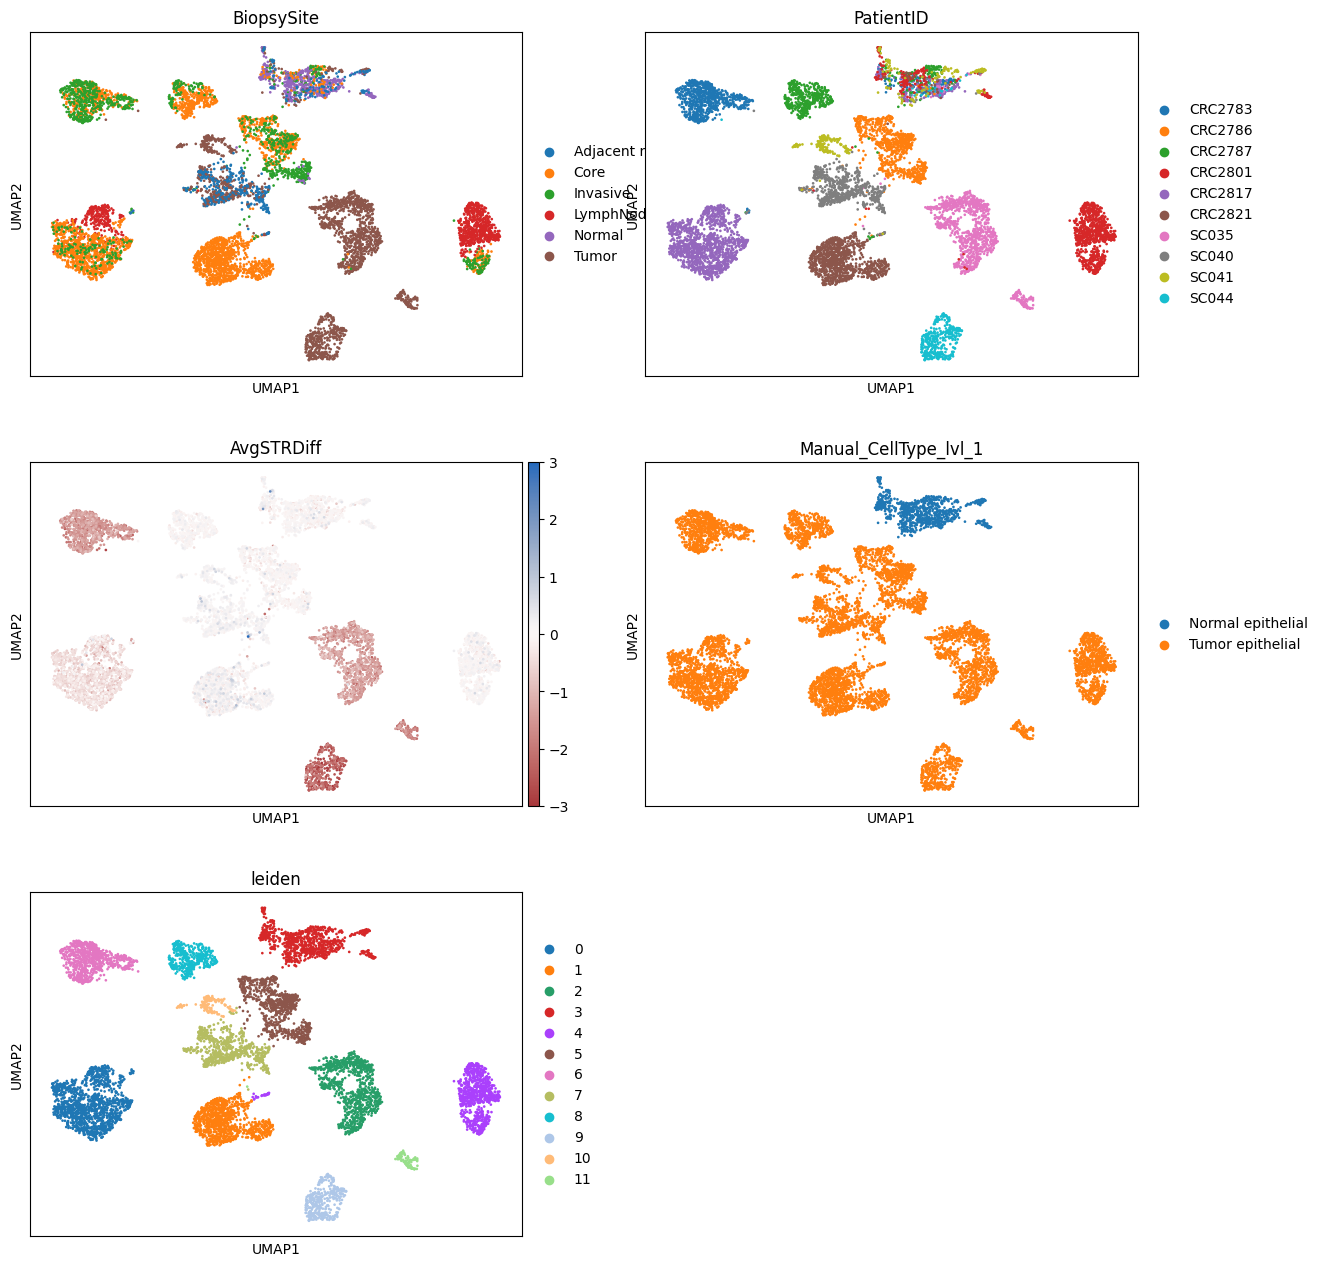

In [409]:
sc.pl.umap(adata_epi, color=['BiopsySite', 'PatientID', 'AvgSTRDiff', 'Manual_CellType_lvl_1', 'leiden'], ncols=2,
           cmap='vlag_r', vmin=-3, vmax=3,
)

In [410]:
# Reload adata because we did adata = adata.raw.to_adata()
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.h5ad')

adata.obs['MSI'] = [ dict_PatientID_to_MSIstatus[PatientID] for PatientID in adata.obs['PatientID'] ]

In [411]:
dict_Identifier_to_ManualCellTypeLvl1 = { tup.Identifier : tup.Manual_CellType_lvl_1 for tup in adata_epi.obs.itertuples() }
for tup in adata.obs.itertuples():
    try:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier]
    except KeyError:
        dict_Identifier_to_ManualCellTypeLvl1[tup.Identifier] = 'N/A'

adata.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_ManualCellTypeLvl1[identifier] for identifier in adata.obs['Identifier'] ]

In [412]:
adata.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')
adata_epi.write('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.h5ad')